# Import Libraries

In [8]:
import tensorflow as tf
from pathlib import Path
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import strftime
import json

# Loading Data

In [9]:
# Load in the Data
dataset_dir = Path("C:/Users/fish2/ResearchWork/DatasetCreationTool/Top3mics_fft=True_autocorr=True")
dataframes = [pd.read_parquet(file) for file in dataset_dir.iterdir() if file.suffix == '.parquet']
df = pd.concat(dataframes, ignore_index=True)

Visualize Class Distributions of Dataset

In [3]:
print(df['DOC'].value_counts())
print(df['RPM'].value_counts())
print(df['Feed_Rate'].value_counts())

DOC
2    18816
1    15300
3     9900
0     9879
Name: count, dtype: int64
RPM
0    23400
2    20616
1     9879
Name: count, dtype: int64
Feed_Rate
6    18000
4     9900
2     7116
5     6300
0     5400
1     3600
3     3579
Name: count, dtype: int64


Seperate the Samples from the Labels

In [10]:
X = np.array(df['Sample_Data'].to_list())
y_fr = np.array(df['Feed_Rate'].to_list())
y_rpm = np.array(df['RPM'].to_list())
y_doc = np.array(df['DOC'].to_list())

# First split: 70% train, 30% temp (test + val)
X_train, X_temp, y_rpm_train, y_rpm_temp, y_fr_train, y_fr_temp, y_doc_train, y_doc_temp = train_test_split(
    X, y_rpm, y_fr, y_doc,
    test_size=0.3,
    random_state=42
)

# Second split: 50% of temp (15% total) to test, 50% (15% total) to validation
X_test, X_val, y_rpm_test, y_rpm_val, y_fr_test, y_fr_val, y_doc_test, y_doc_val = train_test_split(
    X_temp, y_rpm_temp, y_fr_temp, y_doc_temp,
    test_size=0.5,
    random_state=42
)

# Inspect the segment size
print(X_train.shape[-1])

1200


Visualize the composition of the splits

In [5]:
datalength = df.shape
print(f'Shape of the total dataset: {datalength}')
print(f'X_train shape: {X_train.shape} {X_train.shape[0]*100/datalength[0]}% of original,\
      \nX_test shape: {X_test.shape} {X_test.shape[0]*100/datalength[0]}% of original, \
          \nX_val shape: {X_val.shape} {X_val.shape[0]*100/datalength[0]}% of original')

Shape of the total dataset: (53895, 8)
X_train shape: (37726, 1200) 69.99907227015493% of original,      
X_test shape: (8084, 1200) 14.999536135077465% of original,           
X_val shape: (8085, 1200) 15.001391594767604% of original


# Hyperparameter Search With Tuner
First, define the model-returning function, which allows the keras_tuner to instantiate models and search for parameters. In this instance, we will define a branching structure from a shared layer that we can optimize for

In [6]:
def tune_build_model(hp):

    """
    Because this model has three different output targets (RPM, DOC, and Feed Rate), we need to build a model-returning function that can allow the tuner to tune the following hyperparameters:
    - Activation Function
    - Learning Rate
    - Number of Shared layers
    - Number of Neurons in the shared layers
    - Number of RPM, DOC, and Feed Rate hidden layers
    - Number of neurons in the RPM, DOC, and Feed Rate hidden layers
    """
    
    # Hyperparameters
    activation_choice = hp.Choice('activation', values=['relu', 'gelu', 'leaky_relu'])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Shared layers
    n_hidden_shared = hp.Int('n_hidden_shared', min_value=1, max_value=4)
    n_neurons_shared = hp.Int('n_neurons_shared', min_value=1, max_value=500)

    # RPM layers
    n_hidden_RPM = hp.Int('n_hidden_RPM', min_value=1, max_value=4)
    n_neurons_RPM = hp.Int('n_neurons_RPM', min_value=1, max_value=500)

    # DOC layers
    n_hidden_DOC = hp.Int('n_hidden_DOC', min_value=1, max_value=4)
    n_neurons_DOC = hp.Int('n_neurons_DOC', min_value=1, max_value=500)

    # Feed Rate layers
    n_hidden_fr = hp.Int('n_hidden_fr', min_value=1, max_value=4)
    n_neurons_fr = hp.Int('n_neurons_fr', min_value=1, max_value=500)

    # Input layer
    input_layer = tf.keras.Input(shape=X_train.shape[-1])

    # Normalization layer (adapted to training data)
    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)  # Adapt to training data
    x = norm_layer(input_layer)

    # Shared layers
    for _ in range(n_hidden_shared):
        x = tf.keras.layers.Dense(n_neurons_shared, activation=activation_choice)(x)

    # RPM branch
    rpm = x
    for _ in range(n_hidden_RPM):
        rpm = tf.keras.layers.Dense(n_neurons_RPM, activation=activation_choice)(rpm)
    rpm_output = tf.keras.layers.Dense(3, activation='softmax', name='rpm_out')(rpm)  # Named output

    # DOC branch
    doc = x
    for _ in range(n_hidden_DOC):
        doc = tf.keras.layers.Dense(n_neurons_DOC, activation=activation_choice)(doc)
    doc_output = tf.keras.layers.Dense(4, activation='softmax', name='doc_out')(doc)  # Named output

    # Feed Rate branch
    fr = x
    for _ in range(n_hidden_fr):
        fr = tf.keras.layers.Dense(n_neurons_fr, activation=activation_choice)(fr)
    fr_output = tf.keras.layers.Dense(7, activation='softmax', name='feed_rate_out')(fr)  # Named output

    # Instantiate the model
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=[rpm_output, doc_output, fr_output],
        name="Parameter_Predictor"
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Now that we have a function to describe the parameter space we would like to sample, we can use a keras_tuner to search that space and find a good architecture for us to use

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=tune_build_model,
    objective=[kt.Objective(name='val_rpm_out_accuracy', direction='max'),
                kt.Objective(name='val_doc_out_accuracy', direction='max'),
                kt.Objective(name='val_feed_rate_out_accuracy', direction='max')],
    max_trials=10,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    max_consecutive_failed_trials=3,
    directory='search_logs', 
    project_name="bayesiantuner_search"
)

# Tensorboard callback funtion
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

# Create the tensorboard callback
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))

# Search the parameter space
tuner.search(
    X_train,
    {"rpm_out": y_rpm_train, "doc_out": y_doc_train, "feed_rate_out": y_fr_train},  # Use a dictionary for multi-output
    validation_data=(X_val, {"rpm_out": y_rpm_val, "doc_out": y_doc_val, "feed_rate_out": y_fr_val}),
    epochs=7,
    callbacks=[tensorboard_cb]
)

Reloading Tuner from search_logs\bayesiantuner_search\tuner0.json


# Recall Optimal Parameters

#### So far, the best parameters are as follow: 

```
{'Activation Function': 'leaky_relu',
 'learning_rate': 0.0003021384939866327,
 'n_hidden_shared': 3,
 'n_neurons_shared': 464,
 'n_hidden_RPM': 3,
 'n_neurons_RPM': 44,
 'n_hidden_DOC': 3,
 'n_neurons_DOC': 27,
 'n_hidden_fr': 4,
 'n_neurons_fr': 451,
 'activation': 'gelu'}
 ```

In [8]:


# Save the best hyperparameters to a file
top3_params = tuner.get_best_hyperparameters()
best_hyperparameters = top3_params[0].values

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

# Training and Testing the Model

Since we have saved the best parameters in a JSON now, we can use the below function to build the model from that

In [26]:
def build_model_from_config(config, X_train):
    """Builds a multi-output model using fixed parameters from a config dictionary."""
    
    # Extract parameters from config
    activation_choice = config['activation']
    learning_rate = config['learning_rate']
    
    # Shared layers parameters
    n_hidden_shared = config['n_hidden_shared']
    n_neurons_shared = config['n_neurons_shared']
    
    # RPM branch parameters
    n_hidden_RPM = config['n_hidden_RPM']
    n_neurons_RPM = config['n_neurons_RPM']
    
    # DOC branch parameters
    n_hidden_DOC = config['n_hidden_DOC']
    n_neurons_DOC = config['n_neurons_DOC']
    
    # Feed Rate branch parameters
    n_hidden_fr = config['n_hidden_fr']
    n_neurons_fr = config['n_neurons_fr']

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Input layer
    input_layer = tf.keras.Input(shape=X_train.shape[-1])

    # Normalization layer (adapt to training data)
    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)
    x = norm_layer(input_layer)

    # Shared hidden layers
    for _ in range(n_hidden_shared):
        x = tf.keras.layers.Dense(n_neurons_shared, activation=activation_choice)(x)

    # RPM output branch
    rpm = x
    for _ in range(n_hidden_RPM):
        rpm = tf.keras.layers.Dense(n_neurons_RPM, activation=activation_choice)(rpm)
    rpm_output = tf.keras.layers.Dense(3, activation='softmax', name='rpm_out')(rpm)

    # DOC output branch
    doc = x
    for _ in range(n_hidden_DOC):
        doc = tf.keras.layers.Dense(n_neurons_DOC, activation=activation_choice)(doc)
    doc_output = tf.keras.layers.Dense(4, activation='softmax', name='doc_out')(doc)

    # Feed Rate output branch
    fr = x
    for _ in range(n_hidden_fr):
        fr = tf.keras.layers.Dense(n_neurons_fr, activation=activation_choice)(fr)
    fr_output = tf.keras.layers.Dense(7, activation='softmax', name='feed_rate_out')(fr)

    # Create model
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=[rpm_output, doc_output, fr_output],
        name="Parameter_Predictor"
    )

    # Compile model
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [31]:
# Retrieve the hyperparameters from the file and print them out
with open('best_hyperparameters.json', 'r') as f:
    loaded_hyperparameters = dict(json.load(f))

model = build_model_from_config(loaded_hyperparameters, X_train)

# Review the model summary
model.summary()

Model: "Parameter_Predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 normalization_6 (Normalization  (None, 1200)        2401        ['input_7[0][0]']                
 )                                                                                                
                                                                                                  
 dense_78 (Dense)               (None, 464)          557264      ['normalization_6[0][0]']        
                                                                                                  
 dense_79 (Dense)               (None, 464)          215760      ['dense_78[0][0

Train the model

Epoch 1/50
1179/1179 [==============================] - 13s 10ms/step - loss: 0.7263 - rpm_out_loss: 0.0450 - doc_out_loss: 0.1610 - feed_rate_out_loss: 0.5203 - rpm_out_accuracy: 0.9849 - doc_out_accuracy: 0.9449 - feed_rate_out_accuracy: 0.7731 - val_loss: 0.4186 - val_rpm_out_loss: 0.0077 - val_doc_out_loss: 0.0739 - val_feed_rate_out_loss: 0.3370 - val_rpm_out_accuracy: 0.9979 - val_doc_out_accuracy: 0.9740 - val_feed_rate_out_accuracy: 0.8550
Epoch 2/50
1179/1179 [==============================] - 11s 9ms/step - loss: 0.3357 - rpm_out_loss: 0.0096 - doc_out_loss: 0.0486 - feed_rate_out_loss: 0.2775 - rpm_out_accuracy: 0.9980 - doc_out_accuracy: 0.9825 - feed_rate_out_accuracy: 0.8859 - val_loss: 0.3548 - val_rpm_out_loss: 0.0171 - val_doc_out_loss: 0.0579 - val_feed_rate_out_loss: 0.2797 - val_rpm_out_accuracy: 0.9952 - val_doc_out_accuracy: 0.9829 - val_feed_rate_out_accuracy: 0.8900
Epoch 3/50
1179/1179 [==============================] - 11s 10ms/step - loss: 0.2445 - rpm_out_lo

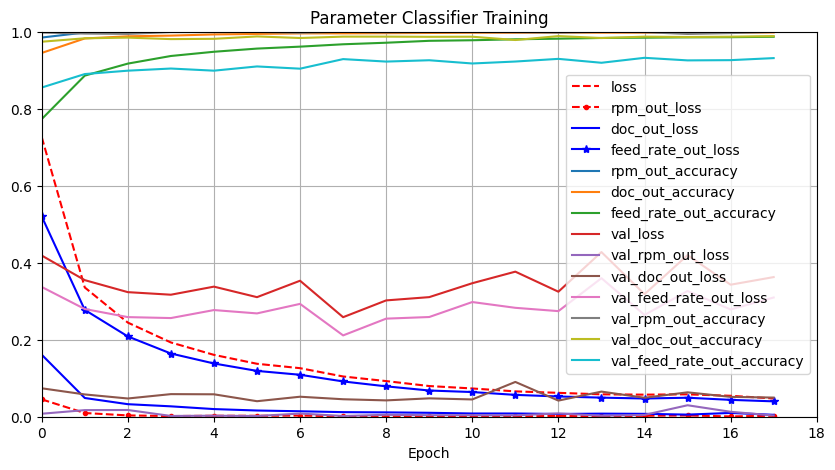

In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train,
    {"rpm_out": y_rpm_train, "doc_out": y_doc_train, "feed_rate_out": y_fr_train},  # Use a dictionary for multi-output
    validation_data=(X_val, {"rpm_out": y_rpm_val, "doc_out": y_doc_val, "feed_rate_out": y_fr_val}),
    epochs=50,
    callbacks=[early_stopping_cb])


actual_epochs = len(history.history["loss"])
pd.DataFrame(history.history).plot(
    figsize=(10, 5), xlim=[0, actual_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], title='Parameter Classifier Training')
plt.show()


Testing the model on the test set

253/253 [==============================] - 1s 3ms/step
Classification Report for RPM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3520
           1       1.00      1.00      1.00      1469
           2       1.00      1.00      1.00      3095

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

Classification Report for DOC:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1531
           1       0.97      0.98      0.98      2304
           2       0.99      0.99      0.99      2795
           3       1.00      1.00      1.00      1454

    accuracy                           0.99      8084
   macro avg       0.99      0.99      0.99      8084
weighted avg       0.99      0.99      0.99      8084

Classification Report for Feed Rate:
              precision    rec

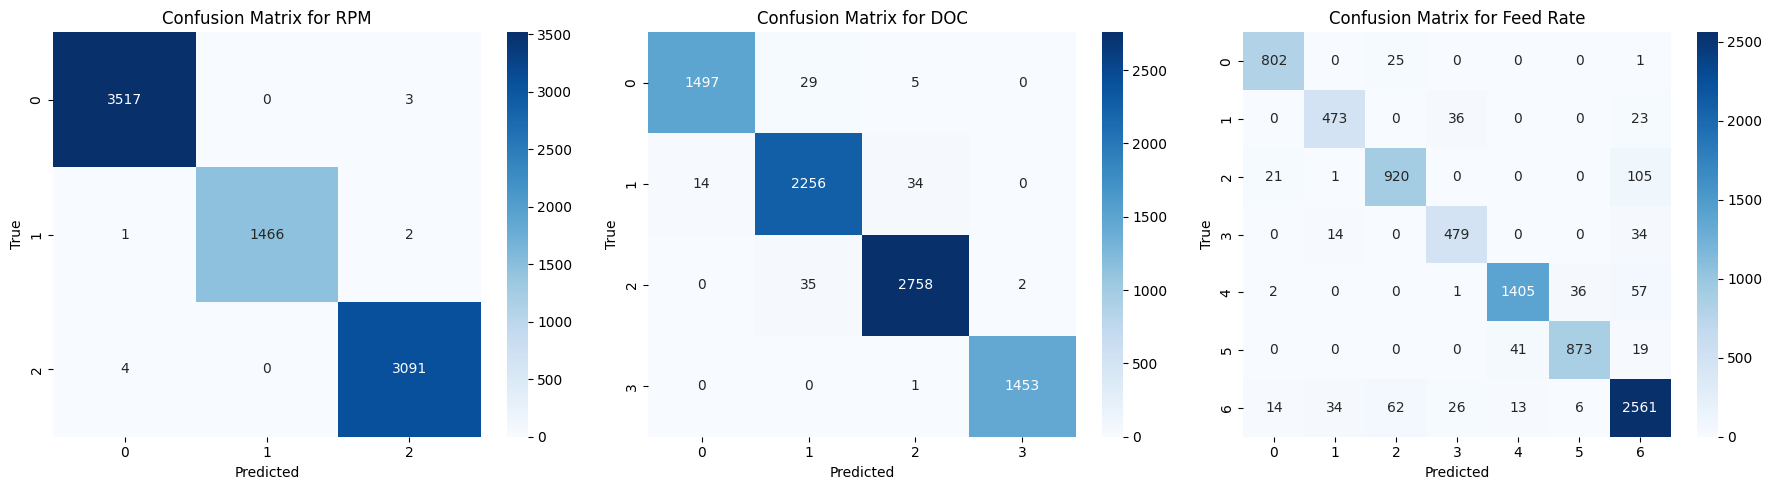

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_rpm = np.argmax(y_pred[0], axis=1)
y_pred_doc = np.argmax(y_pred[1], axis=1)
y_pred_fr = np.argmax(y_pred[2], axis=1)

# Classification reports
print("Classification Report for RPM:")
print(classification_report(y_rpm_test, y_pred_rpm))

print("Classification Report for DOC:")
print(classification_report(y_doc_test, y_pred_doc))

print("Classification Report for Feed Rate:")
print(classification_report(y_fr_test, y_pred_fr))

# Confusion matrices
conf_matrix_rpm = confusion_matrix(y_rpm_test, y_pred_rpm)
conf_matrix_doc = confusion_matrix(y_doc_test, y_pred_doc)
conf_matrix_fr = confusion_matrix(y_fr_test, y_pred_fr)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(conf_matrix_rpm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix for RPM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_matrix_doc, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix for DOC')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(conf_matrix_fr, annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Confusion Matrix for Feed Rate')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()


In [ ]:
# Save the moddel 
model.save('trained_model_top3.h5')